In [283]:
%load_ext autoreload
%autoreload 2
import random
from Environment import Environment
from CompanyAgent import CompanyAgent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [324]:
def generate_agents(
        count,
        expected_emission, 
        initial_allowance, 
        sell_price, 
        buy_price, 
        activate_abatement=True, 
        emission_rate_noise=0.01, 
        expected_emission_noise=0.1,
        advanced_trading=False):
    print(expected_emission)
    agents = []
    for i in range(count):
        agents.append(CompanyAgent(
            np.random.uniform(*expected_emission),
            np.random.uniform(*initial_allowance),
            np.random.uniform(*sell_price),
            np.random.uniform(*buy_price),
            activate_abatement=activate_abatement,
            emission_rate_noise=emission_rate_noise,
            expected_emission_noise=expected_emission_noise,
            advanced_trading=advanced_trading))
    return agents


In [143]:
def init_eu(emission_rate_noise=0.1, expected_emission_noise=0.1):
    df = pd.read_csv("./data/data_for_init_melted.csv")
    training_data = df[['year', 'INSTALLATION_NAME', 'ALLOCATION_', 'VERIFIED_EMISSIONS_']][df.year==2018].dropna()
    training_data = training_data[['ALLOCATION_', 'VERIFIED_EMISSIONS_']].to_numpy().tolist()

    agents = []
    for i in range(len(training_data)):
        agents.append(CompanyAgent(
            training_data[i][1],
            training_data[i][0],
            0.0,
            1000000,
            activate_abatement=False,
            emission_rate_noise=0.1,
            expected_emission_noise=0.1,
            advanced_trading=True))

    return agents

(10000, 11000)
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abatement_cost_per_ton: inf
abate

  0%|          | 0/365 [00:00<?, ?it/s]

abate
abate
abate
abate
abate
abate
abate
abate
abate
hi


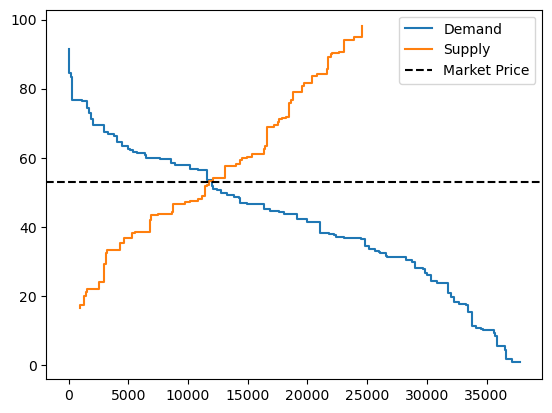

abate
abate
abate
abate
abate
hi


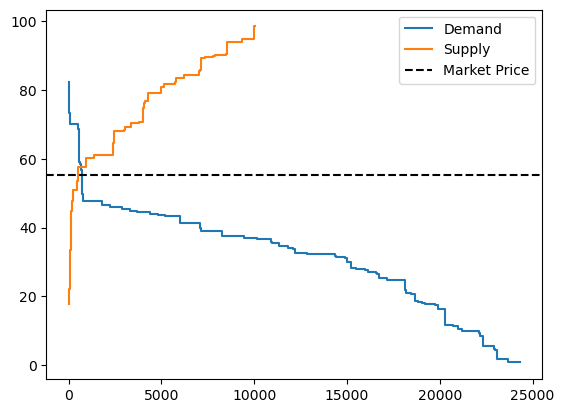

abate
abate
abate
abate
abate
hi


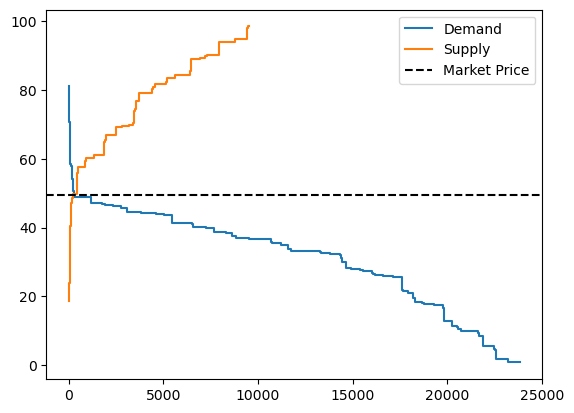

  1%|          | 3/365 [00:00<00:17, 21.00it/s]

abate
abate
abate
abate
abate
abate
abate


100%|██████████| 365/365 [00:00<00:00, 1236.75it/s]


In [332]:
random.seed(41)
np.random.seed(41)
# create two agents
# define 100 agents with random expected emission, initial allowance, sell price and buy pric

states = ['idle', 'simple_trade', 'simple_trade_deficit', 'noise_trade_deficit']

state = "noise_trade_deficit_abatement"
state = "random_uniform"
state = "eu"

agents = []
if state == "idle":
    #base state, everyone has what he needs
    idle_agents = generate_agents(
        1000, 
        (10000,10000), 
        (10000,10000), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0, 
        expected_emission_noise=0)
    agents += idle_agents

if state == "simple_trade":
    #trading but market is saturated behavior
    selling_agents = generate_agents(
        100, 
        (10000,10000), 
        (10100, 10100), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0, 
        expected_emission_noise=0)
    buying_agents = generate_agents(
        100, 
        (10000,10000), 
        (9900, 9900), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0, 
        expected_emission_noise=0)
    agents += selling_agents
    agents += buying_agents

if state == "simple_trade_deficit":
    #trading but market has a dificit
    selling_agents = generate_agents(
        100, 
        (10000,10000), 
        (10100, 10100), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0, 
        expected_emission_noise=0)
    buying_agents = generate_agents(
        100, 
        (10000,10000), 
        (9800, 9800), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0, 
        expected_emission_noise=0)
    agents += selling_agents
    agents += buying_agents

if state == "noise_trade_deficit":
    #trading but market has a dificit
    selling_agents = generate_agents(
        100, 
        (10000,10000), 
        (10100, 10100), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0.1, 
        expected_emission_noise=0.1)
    buying_agents = generate_agents(
        100, 
        (10000,10000), 
        (9800, 9800), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0.1, 
        expected_emission_noise=0.1)
    agents += selling_agents
    agents += buying_agents

if state == "noise_trade_deficit_advanced":
    #trading but market has a dificit
    selling_agents = generate_agents(
        100, 
        (10000,10000), 
        (10100, 10100), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0.1, 
        expected_emission_noise=0.1)
    buying_agents = generate_agents(
        100, 
        (10000,10000), 
        (9800, 9800), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0.1, 
        expected_emission_noise=0.1,
        advanced_trading=True)
    agents += selling_agents
    agents += buying_agents

if state == "noise_trade_deficit_abatement_advanced":
    #trading but market has a dificit
    selling_agents = generate_agents(
        100, 
        (10000,10000), 
        (10100, 10100), 
        (0,0), 
        (100,100),
        activate_abatement=True, 
        emission_rate_noise=0.1, 
        expected_emission_noise=0.1)
    buying_agents = generate_agents(
        100, 
        (10000,10000), 
        (9800, 9800), 
        (0,0), 
        (100,100),
        activate_abatement=True, 
        emission_rate_noise=0.1, 
        expected_emission_noise=0.1,
        advanced_trading=True)
    agents += selling_agents
    agents += buying_agents

if state == "noise_trade_saturation":
    #trading but market has a dificit
    selling_agents = generate_agents(
        100, 
        (10000,10000), 
        (10200, 10200), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0.1, 
        expected_emission_noise=0.1)
    buying_agents = generate_agents(
        100, 
        (10000,10000), 
        (9900, 9900), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0.1, 
        expected_emission_noise=0.1)
    agents += selling_agents
    agents += buying_agents

if state == "random_uniform":
    #trading but market has a dificit
    selling_agents = generate_agents(
        100, 
        (10000,11000), 
        (10100, 11100), 
        (0,100), 
        (0,100),
        activate_abatement=False, 
        emission_rate_noise=0.1, 
        expected_emission_noise=0.1)
    buying_agents = generate_agents(
        100, 
        (10000,11000), 
        (9800, 10800), 
        (0,100), 
        (0,100),
        activate_abatement=True, 
        emission_rate_noise=0.1, 
        expected_emission_noise=0.1,
        advanced_trading=True)
    agents += selling_agents
    agents += buying_agents
   

if state == "eu":
    agents = init_eu()


env = Environment(5, agents, mode="seller_preferred")
print("start simulation")
for i in tqdm.tqdm(range(365)):
    if i < 3:# or (i > 188 and i < 193):    
        env.update(plot=True)
    else:
        env.update(plot=False)

for agent in env.agents:
    env.track_agent_state(agent)


trade_df = pd.DataFrame(env.trade_hist_dict)
market_df = pd.DataFrame(env.market_hist_dict)
agent_df = pd.DataFrame(env.agent_hist_dict)

#join the two dataframes on days
df = pd.merge(trade_df, market_df, how = "right", on="day")

/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

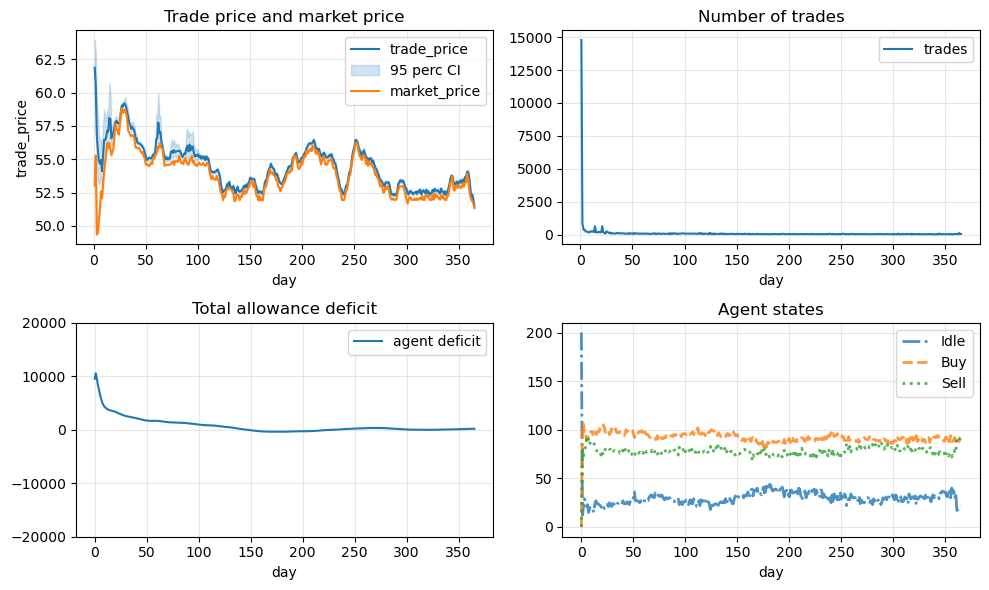

In [333]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

grid = True
grid_alpha = 0.3

# Plot 1: Lineplot for trade_price and market_price
try:
    sns.lineplot(x="day", y="trade_price", data=df, ax=axes[0, 0])
    sns.lineplot(x="day", y="market_price", data=df, ax=axes[0, 0])
except:
    print("No trades were made")
axes[0, 0].legend(["trade_price", "95 perc CI","market_price"])
axes[0, 0].title.set_text("Trade price and market price")
axes[0, 0].grid(grid, alpha=grid_alpha)

# Plot 2: Lineplot for trade_price count
df.groupby("day").sum().trade_amount.plot(kind="line", ax=axes[0, 1])
axes[0, 1].legend(["trades"])
axes[0, 1].title.set_text("Number of trades")
axes[0, 1].grid(grid, alpha=grid_alpha)

# Plot 3: Lineplot for agent deficit
agent_df.groupby("day").deficit.sum().plot(kind="line", ax=axes[1, 0], alpha=1)
axes[1, 0].legend(["agent deficit"])
axes[1, 0].title.set_text("Total allowance deficit")
#set ylim to 0 to 20000
axes[1, 0].set_ylim([-20000, 20000])
axes[1, 0].grid(grid, alpha=grid_alpha)

# Plot 4: Lineplot for agent count separated by state
state_counts = agent_df.groupby("day").state.value_counts().unstack(fill_value=0)
try:
    state_counts['idle'].plot(kind="line", linestyle='-.',ax=axes[1, 1], alpha = 0.8, lw=2)  # Solid line for 'idle'
except:
    print("No idles were made")
try:
    state_counts['buy'].plot(kind="line", linestyle='--', ax=axes[1, 1], alpha = 0.8, lw=2)  # Dashed line for 'buy'
except:
    print("No buys were made")
try:
    state_counts['sell'].plot(kind="line", linestyle=':', ax=axes[1, 1], alpha = 0.8, lw=2)  # Dotted line for 'sell'
except:
    print("No sells were made")

axes[1, 1].legend(["Idle", "Buy", "Sell"])
axes[1, 1].grid(grid, alpha=grid_alpha)
axes[1, 1].title.set_text("Agent states")


# Adjust layout
plt.tight_layout()
plt.show()

In [287]:
#get number of agents each day
agent_df[agent_df.day==365].value_counts("state")

state
idle    91
buy     88
sell    21
Name: count, dtype: int64

day  state
0    idle     200
1    buy      100
     sell     100
2    buy       96
     idle       2
             ... 
364  idle      13
     sell      99
365  buy       88
     idle      14
     sell      98
Name: state, Length: 1093, dtype: int64

In [53]:
agent_df.groupby(["day", "state"]).sum()

deficit  count
day state                
0   idle       0.0      0
1   buy    10440.0   6718
    sell   -9526.0   5804
2   buy     7270.0   6467
    idle       0.0      0
...            ...    ...
364 idle       0.0      0
    sell  -18638.0  18599
365 buy    16428.0  16392
    idle       0.0      0
    sell  -18661.0  18625

[1093 rows x 2 columns]

<Axes: xlabel='day'>

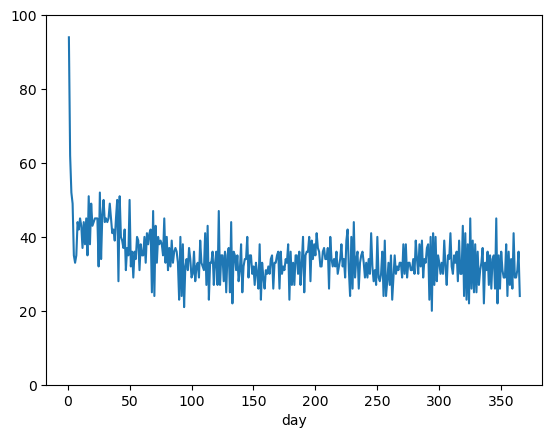

In [54]:
df.groupby("day").trade_price.count().plot(ylim=[0, 100])


In [55]:
import numpy as np
import numpy
q_supplier = np.random.normal(0, 1, 10000)
p_supplier = np.random.normal(0, 1, 10000)
q_demander = np.random.normal(0, 1, 10000)
p_demander = np.random.normal(0, 1, 10000)

In [56]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = numpy.result_type(*arrays)
    arr = numpy.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(numpy.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [57]:
q_supplier = np.array([1, 5, 8, 10])
p_supplier = np.array([0.3, 0.5, 0.7, 0.9])
q_demander = np.array([1, 3, 12, 15])
p_demander = np.array([1.2, 1.0, 0.8, 0.1])

In [58]:
sns.

SyntaxError: invalid syntax (1118962691.py, line 1)

In [ ]:
q_res = cartesian_product(q_supplier, q_demander)
p_res = cartesian_product(p_supplier, p_demander)

In [ ]:
np.argmax((q_res[:,0] >= q_res[:,1]) & (p_res[:,0] > p_res[:,1]))

0